Loaded data with shape: (358, 18).
(100.0, 1000.0, 10000.0) frequencies found


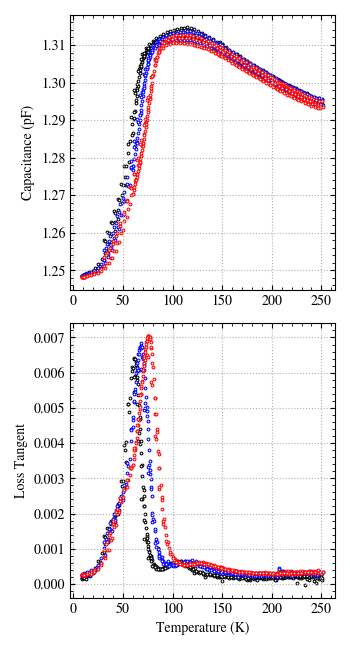

In [1]:
from fitting.debye33 import Debye33
from fitting.data import DataSetOld
from pathlib import Path
import numpy as np
import matplotlib.pylab as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["mathtext.fontset"] = "cm"
%matplotlib widget

dir = Path(r'C:\Users\Teddy\OneDrive - UCB-O365\Rogerslab3\Teddy\Thesis\chapter-4\Data\BDS')

# calibration_files = list(dir.glob("Calibration*"))
# data_files = list(dir.glob("HeliumCool*"))

data_file = list((dir / "1@TPP sat - GBA 124").glob("*"))[1]
data = DataSetOld(data_file)
fig, _ = data.show()

(1000, 3)
(1000, 3)


(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel='$\\tan\\delta$'>],
       dtype=object))

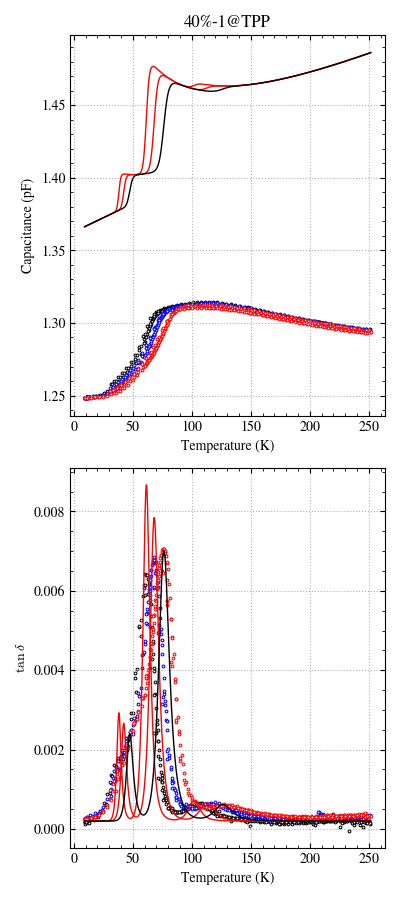

In [2]:
fit = Debye33(data, "40%-1@TPP")
fit.bare0 = 1
fit.set_population(1, 1)
fit.set_population(2, 5)
fit.set_population(3, .5)
fit.activation_energy1 = 900
fit.activation_energy2 = 1450
fit.activation_energy3 = 2400
fit.td0 = 2e-4
fit.show_fit()